# DEVICE INPUT-OUTPUT

In [1]:
import sounddevice as sd

# Query audio devices
devices = sd.query_devices()
print(devices)

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Microphone (HD Webcam C525), MME (1 in, 0 out)
   2 IN 1-2 (BEHRINGER UMC 404HD 192, MME (2 in, 0 out)
   3 Headset Microphone (Oculus Virt, MME (1 in, 0 out)
   4 Microphone (Voicemod Virtual Au, MME (2 in, 0 out)
   5 VoiceMeeter Aux Output (VB-Audi, MME (8 in, 0 out)
   6 VoiceMeeter Output (VB-Audio Vo, MME (8 in, 0 out)
   7 CABLE Output (VB-Audio Virtual , MME (8 in, 0 out)
   8 Microphone (Bigscreen Audio Str, MME (2 in, 0 out)
   9 IN 3-4 (BEHRINGER UMC 404HD 192, MME (2 in, 0 out)
  10 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
< 11 VoiceMeeter Input (VB-Audio Voi, MME (0 in, 8 out)
  12 OUT 1-2 (BEHRINGER UMC 404HD 19, MME (0 in, 2 out)
  13 OUT 3-4 (BEHRINGER UMC 404HD 19, MME (0 in, 2 out)
  14 VoiceMeeter Aux Input (VB-Audio, MME (0 in, 8 out)
  15 VoiceMeeter Input (VB-Audio Vir, MME (0 in, 8 out)
  16 Headphones (Oculus Virtual Audi, MME (0 in, 2 out)
  17 Line (Voicemod Virtual Audio De, MME (0 in, 2 ou

In [2]:
input_devices = sd.query_devices(kind='input')
print(input_devices)

{'name': 'Microphone (2- HD Webcam C525)', 'hostapi': 0, 'max_input_channels': 1, 'max_output_channels': 0, 'default_low_input_latency': 0.09, 'default_low_output_latency': 0.09, 'default_high_input_latency': 0.18, 'default_high_output_latency': 0.18, 'default_samplerate': 44100.0}


In [3]:
output_devices = sd.query_devices(kind='output')
print(output_devices)

{'name': 'VoiceMeeter Input (VB-Audio Voi', 'hostapi': 0, 'max_input_channels': 0, 'max_output_channels': 8, 'default_low_input_latency': 0.09, 'default_low_output_latency': 0.09, 'default_high_input_latency': 0.18, 'default_high_output_latency': 0.18, 'default_samplerate': 44100.0}


In [4]:
print(sd.default.device)

[1, 11]


# WORKING RECORDER

In [2]:
def float2pcm(sig, dtype='int16'):
    """Convert floating point signal with a range from -1 to 1 to PCM.
    Any signal values outside the interval [-1.0, 1.0) are clipped.
    No dithering is used.
    Note that there are different possibilities for scaling floating
    point numbers to PCM numbers, this function implements just one of
    them.  For an overview of alternatives see
    http://blog.bjornroche.com/2009/12/int-float-int-its-jungle-out-there.html
    Parameters
    ----------
    sig : array_like
        Input array, must have floating point type.
    dtype : data type, optional
        Desired (integer) data type.
    Returns
    -------
    numpy.ndarray
        Integer data, scaled and clipped to the range of the given
        *dtype*.
    See Also
    --------
    pcm2float, dtype
    """
    sig = np.asarray(sig)
    if sig.dtype.kind != 'f':
        raise TypeError("'sig' must be a float array")
    dtype = np.dtype(dtype)
    if dtype.kind not in 'iu':
        raise TypeError("'dtype' must be an integer type")

    i = np.iinfo(dtype)
    abs_max = 2 ** (i.bits - 1)
    offset = i.min + abs_max
    return (sig * abs_max + offset).clip(i.min, i.max).astype(dtype)


In [ ]:
import numpy as np
import sounddevice as sd
import scipy.io.wavfile as wav
import soundfile as sf

# Set the parameters for recording
fs = 44100  # Sample rate
duration = 2  # Recording duration in seconds
threshold = 0.2  # Volume threshold for recording to start

# Initialize the recording array
recording = np.array([])
record = True

def callback(indata, frames, time, status):
    global recording, record
    #print(np.abs(indata).max())
    if np.abs(indata).max() > threshold:
        if len(recording) == 0:
            print("Recording started...")
        # Convert the float data to integer data and add it to the recording array
        #int_data = np.int16(indata * 32767)
        #int_data = (indata * 32767).astype(np.int16)
        
        recording = np.append(recording, indata)
    else:
        if len(recording) > 0:
            print("Recording stopped.")
            filename = "recording.wav"
            # Convert the recording array back to float data and save it as a wav file
            float_data = recording / 32767.0
            #wav.write(filename, fs, recording)
            datarec = float2pcm(recording)
            sf.write(file=filename, data=datarec, samplerate=fs, subtype='PCM_24')
            print(f"Saved {filename}.")
            recording = np.array([])
            record = False

# Start the sounddevice stream
with sd.InputStream(channels=1, blocksize=2048, callback=callback):
    #sd.sleep(duration * 1000)
    while record:
        pass

    

import IPython.display as ipd
ipd.Audio('recording.wav')

## RECORD WITH SPECTOGRAPH

Recording started...
Recording stopped.
Saved spectrogram.png.
Recording started...
Recording stopped.
Saved spectrogram.png.


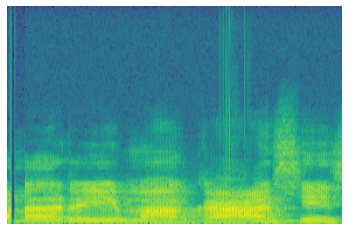

In [6]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt

# Set the parameters for recording
fs = 44100  # Sample rate
duration = 5  # Recording duration in seconds
threshold = 0.1  # Volume threshold for recording to start

# Initialize the recording array
recording = np.array([])

def callback(indata, frames, time, status):
    global recording
    if np.abs(indata).max() > threshold:
        if len(recording) == 0:
            print("Recording started...")
        # Add the new data to the recording array
        recording = np.append(recording, indata)
    else:
        if len(recording) > 0:
            print("Recording stopped.")
            # Generate and save the spectrogram image
            plt.specgram(recording, Fs=fs)
            plt.axis('off')
            plt.savefig('spectrogram.png', bbox_inches='tight', pad_inches=0, dpi=512)
            print("Saved spectrogram.png.")
            recording = np.array([])

# Start the sounddevice stream
with sd.InputStream(channels=1, blocksize=2048, callback=callback):
    sd.sleep(duration * 1000)

### V.2

In [4]:
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt


# Define the duration of the audio recording in seconds
duration = 1

# Define the audio sampling rate
sample_rate = 16000

# Define the audio threshold level in dBFS
threshold_level = 0.2

# Define the audio callback function
def audio_callback(indata, frames, time, status):
    global record
    # Check if the audio input is clipping (going over the maximum level)
    #print(np.max(np.abs(indata)))
    if np.max(np.abs(indata)) > threshold_level:
        print("Threshold triggered!")
        # Record audio for the duration defined earlier
        audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
        # Wait for the audio to finish recording
        sd.wait()
        record = False

        audio = float2pcm(audio)
        filename="recorded_audio.wav"
        sf.write(file=filename, data=audio, samplerate=sample_rate, subtype='PCM_24')

record = True
# Start the audio stream with the audio callback function
with sd.InputStream(callback=audio_callback):
    # Keep the program running indefinitely
    while record:
        pass


import IPython.display as ipd
ipd.Audio('recorded_audio.wav')

KeyboardInterrupt: 